RNN Stuff

In [44]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
import os
import numpy as np
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import accuracy_score


In [17]:
rs=121
ns=5
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [18]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output_kalman.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','HighR','LowR','Volatility']
data_features=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
#features=['Smooth_'+x for x in features]+['Volatility','Smooth_Volume']
target='State'
data[features]=data_features[features]

In [19]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
l=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    l.append(x[1][:-ft_size])

In [20]:
def createSlidingWindowRNN(tr,te,f,t, window=7):
    splitting=SlidingWindowSplitter(window_length=window,step_length=1,fh=[1])
    train_x=[]
    train_y=[]
    test_x=[]
    test_y=[]
    
    for i in splitting.split(tr):
        train_x.append(tr.iloc[i[0]][f].values)
        train_y.append(tr.iloc[i[1]][t].values)
    
    for i in splitting.split(te):
        test_x.append(te.iloc[i[0]][f].values)
        test_y.append(te.iloc[i[1]][t].values)
    return ((train_x,train_y),(test_x,test_y))

In [21]:
testing_size=500

tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
training_list=[]
testing_list=[]
for j in range(len(l)):
    ttl=[]
    tstl=[]
    for i in range(ns):
        ttl.append([[],[]])
        tstl.append([[],[]])
    training_list.append(ttl)
    testing_list.append(tstl)
spread = 13
for (j,x) in enumerate(l):
    for (i,t) in enumerate(tss.split(x)):
        ((train_x,train_y),(test_x,test_y))=createSlidingWindowRNN(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
        training_list[j][i][0] += train_x
        training_list[j][i][1] += train_y
        testing_list[j][i][0] += test_x
        testing_list[j][i][1] += test_y

In [22]:
len(training_list[0])

5

In [ ]:
def build_model(train,test,epochs = 30, batch_size=64):
	train_x, train_y = np.array(train[0]),np.array(train[1])
	test_x, test_y=np.array(test[0]),np.array(test[1])
	verbose  = 1
	n_timesteps, n_features, n_outputs = len(train_x[0]), len(train_x[0][0]), len(train_y[0])
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu',return_sequences=False))
	model.add(Dense(100, activation='relu'))
	model.add(Dropout(0.8, seed=121))
	model.add(Dense(n_outputs,activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(test_x,test_y))
	return model


In [24]:
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [41]:
len(training_list)

7

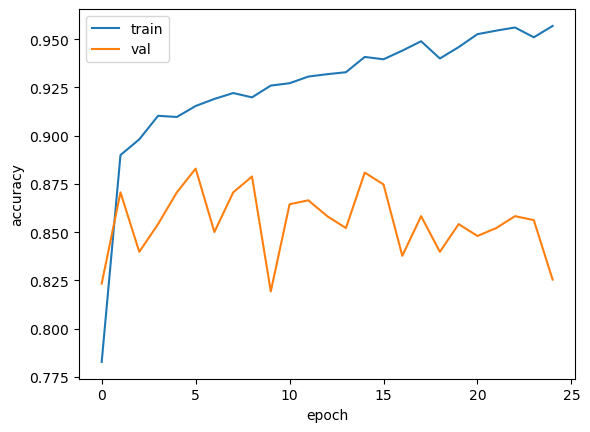

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


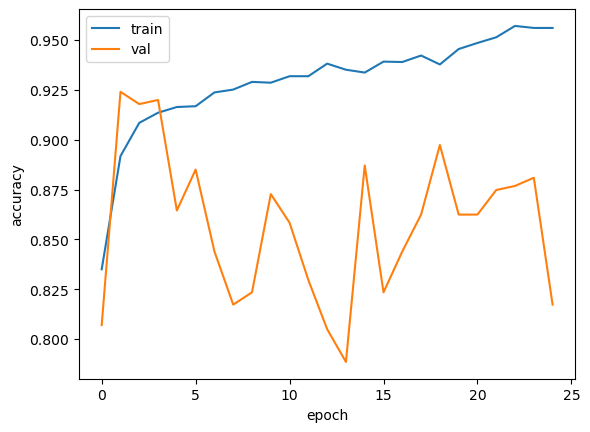

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


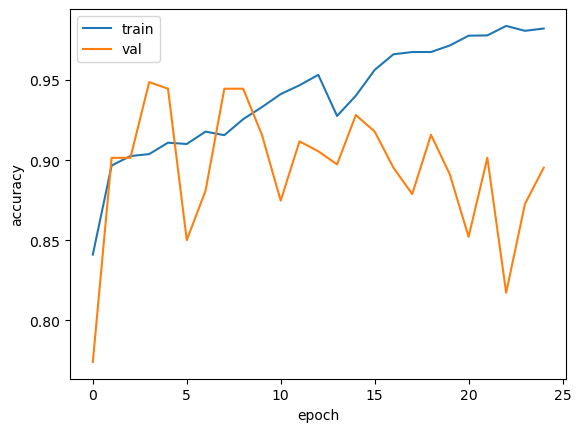

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


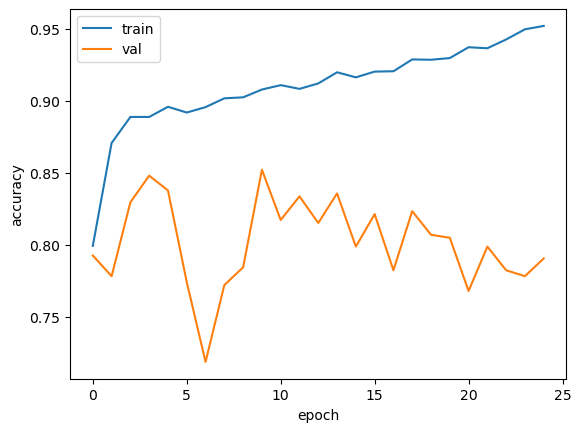

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


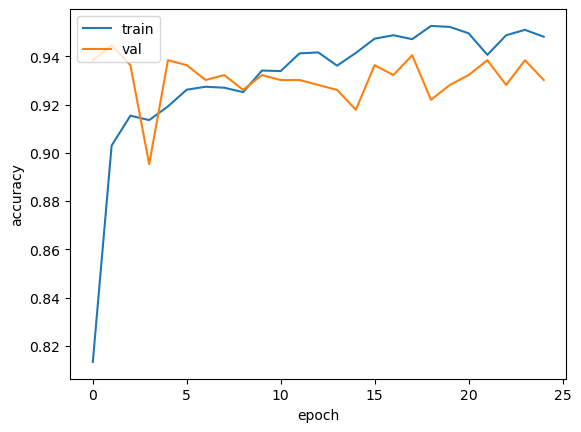

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


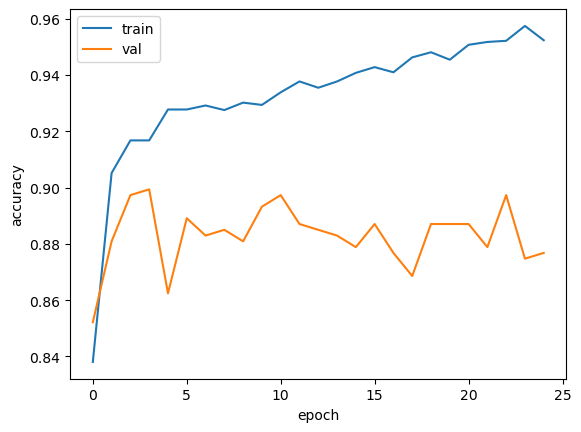

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


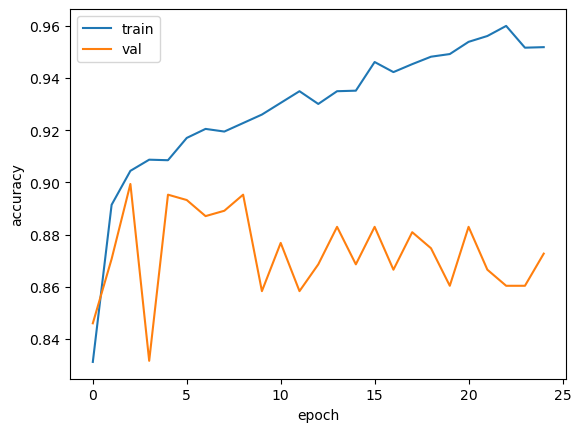

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [49]:
accuracies=[]
for si in range(len(stocks)):
    train=training_list[si][-1]
    test=testing_list[si][-1]
    train_x, train_y = np.array(train[0]),np.array(train[1])
    test_x, test_y=np.array(test[0]),np.array(test[1])
    verbose  = 1
    n_timesteps, n_features, n_outputs = len(train_x[0]), len(train_x[0][0]), len(train_y[0])
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu',return_sequences=False))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.8, seed=121))
    model.add(Dense(n_outputs,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.fit(train_x, train_y, epochs=25, batch_size=32, verbose=0,validation_data=(test_x,test_y))
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    test_output = np.floor(model.predict(np.array(testing_list[0][-1][0]))*2)
    accuracies.append(accuracy_score(test_output,np.array(testing_list[0][-1][1]).astype(float)))


In [47]:
accuracies

[0.7679671457905544,
 0.7351129363449692,
 0.6303901437371663,
 0.8090349075975359,
 0.62217659137577,
 0.7084188911704312,
 0.6919917864476386]

In [32]:
model=build_model(training_list[0][-1],testing_list[0][-1])

2
4917 4917
Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6263 - loss: 0.5683 - val_accuracy: 0.8090 - val_loss: 0.4343
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8658 - loss: 0.3185 - val_accuracy: 0.8378 - val_loss: 0.3495
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8858 - loss: 0.2802 - val_accuracy: 0.8398 - val_loss: 0.3222
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8804 - loss: 0.2848 - val_accuracy: 0.8460 - val_loss: 0.3195
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8830 - loss: 0.2645 - val_accuracy: 0.8583 - val_loss: 0.3351
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8974 - loss: 0.2592 - val_accuracy: 0.8604 - val_loss: 0.3282
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9036 - loss: 0.2317 - val_accuracy: 0.8665 - val_loss: 0.2941
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9065 - loss: 0.2386 - val_accuracy: 0.8419

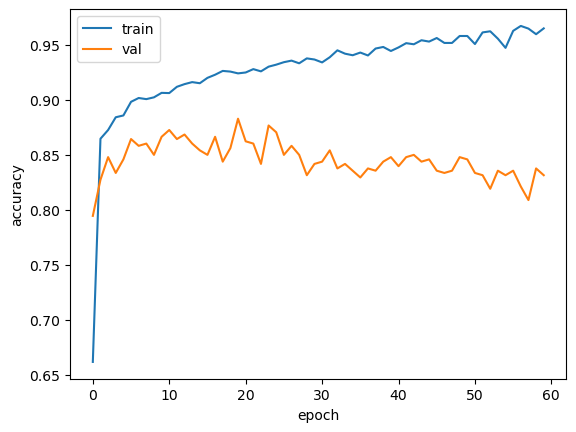

In [26]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
test_output = np.floor(model.predict(np.array(testing_list[0][-1][0]))*2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [34]:
accuracy_score(test_output,np.array(testing_list[0][-1][1]).astype(float))

0.8090349075975359

In [35]:
accuracy_score([0]*len(testing_list[0][-1][1]),np.array(testing_list[0][-1][1]).astype(float))

0.6057494866529775